# A new tool for detecting prostate cancers


## 1. Introduction
In this notebook, we will classify prostate cancer dataset. The cancer is categorised into four classes(0,1,2,3) based on the attribute `Result`. There are a few missing values which will need to be addressed before we move on to choosing the best classification method.

## 2. Load Libraries

In [97]:
library(data.table)
library(reshape)
library(ggplot2)
library(gridExtra)
library(GGally)
library(mice)
library(VIM)
library(glmnet)
library(dplyr)
library(caret)
# SVM
library(e1071)
# CART
library(rpart)
library(rpart.plot)
library(randomForest)

## 3. Load and Examine Data

In [98]:
data <- read.csv('data3000Final.csv', header = TRUE)

# check
head(data)

ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,4,1,4,3,7,1,2,6,8,0
2,?,8,9,1,1,1,1,5,6,1,1
3,10,7,?,7,?,5,2,7,1,1,2
4,3,4,3,?,2,8,4,6,7,2,1
5,3,5,2,1,6,5,3,1,7,1,0
6,2,7,3,2,1,4,10,3,9,5,1


**Initial view of the data**<br>
There are a total of 12 attributes in the data set. They are `ID`, `ATT1~ATT10`(which are lab test results), and a `Result` column that takes in a range of values from 0 to 3, indicating the severeness of the cancer.<br><br>
There are no `NA` values in the dataset, however, from `str()`, we see that `ATT1, ATT3, ATT4, ATT5` contains question marks. From the brief we know that *All the features are numerical measurements rounded to the closest integer number between 1 and 10.* Therefore, these values will need to be further examined and addressed.

In [99]:
# check for NA
cat("Check data for any NA values")
table(is.na(data))

# structure
cat("\n", "Check the structure of the data", "\n")
str(data)

# dimension
cat("\n", "The dimension of the data", "\n")
dim(data)

Check data for any NA values


FALSE 
36000 


 Check the structure of the data 
'data.frame':	3000 obs. of  12 variables:
 $ ID    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ ATT1  : Factor w/ 11 levels "?","1","10","2",..: 2 1 3 5 5 4 2 10 4 2 ...
 $ ATT2  : int  4 8 7 4 5 7 1 5 9 1 ...
 $ ATT3  : Factor w/ 11 levels "?","1","10","2",..: 2 11 1 5 4 5 5 4 4 2 ...
 $ ATT4  : Factor w/ 11 levels "?","1","10","2",..: 6 2 9 1 2 4 7 8 2 10 ...
 $ ATT5  : Factor w/ 11 levels "?","1","10","2",..: 5 2 1 4 8 2 11 4 6 11 ...
 $ ATT6  : int  7 1 5 8 5 4 3 7 6 2 ...
 $ ATT7  : int  1 1 2 4 3 10 7 3 8 2 ...
 $ ATT8  : int  2 5 7 6 1 3 1 6 8 5 ...
 $ ATT9  : int  6 6 1 7 7 9 10 7 4 1 ...
 $ ATT10 : int  8 1 1 2 1 5 7 3 3 3 ...
 $ Result: int  0 1 2 1 0 1 1 1 1 0 ...

 The dimension of the data 


[1] 3000   12

**Replace `?` with `NA`**<br>
First, we will replace the question marks with `NA`, remove the factors and drop the `ID` column, as it does not contain any useful information.

In [100]:
# remove factor levels
data <- transform(data, ATT1 = as.character(ATT1), 
          ATT3 = as.character(ATT3),
          ATT4 = as.character(ATT4),
          ATT5 = as.character(ATT5))

# replace "?" with NA
for (i in 1:nrow(data)){
    data[i,which(data[i,]=='?')] <- NA
}

# convert to numeric data type
data <- transform(data, ATT1 = as.numeric(ATT1), 
          ATT3 = as.numeric(ATT3),
          ATT4 = as.numeric(ATT4),
          ATT5 = as.numeric(ATT5))

# drop the id column
data <- data[-1]

# check
str(data)

'data.frame':	3000 obs. of  11 variables:
 $ ATT1  : num  1 NA 10 3 3 2 1 8 2 1 ...
 $ ATT2  : int  4 8 7 4 5 7 1 5 9 1 ...
 $ ATT3  : num  1 9 NA 3 2 3 3 2 2 1 ...
 $ ATT4  : num  4 1 7 NA 1 2 5 6 1 8 ...
 $ ATT5  : num  3 1 NA 2 6 1 9 2 4 9 ...
 $ ATT6  : int  7 1 5 8 5 4 3 7 6 2 ...
 $ ATT7  : int  1 1 2 4 3 10 7 3 8 2 ...
 $ ATT8  : int  2 5 7 6 1 3 1 6 8 5 ...
 $ ATT9  : int  6 6 1 7 7 9 10 7 4 1 ...
 $ ATT10 : int  8 1 1 2 1 5 7 3 3 3 ...
 $ Result: int  0 1 2 1 0 1 1 1 1 0 ...


**Remove rows with `NA`**<br>
Next, we will remove the rows with `NA`s and assign this to a new variable `data.r`. This will give us a clean dataset for exploratory analysis. 

In [101]:
# remove the rows with NA
data.r <- na.omit(data)

# check
cat("\n---------------------------- Structure of data.r ----------------------------\n\n")
str(data.r)
cat("\n---------------------------- Summary of data.r ----------------------------\n")
summary(data.r)


---------------------------- Structure of data.r ----------------------------

'data.frame':	2997 obs. of  11 variables:
 $ ATT1  : num  1 3 2 1 8 2 1 9 6 5 ...
 $ ATT2  : int  4 5 7 1 5 9 1 3 2 2 ...
 $ ATT3  : num  1 2 3 3 2 2 1 5 2 8 ...
 $ ATT4  : num  4 1 2 5 6 1 8 7 1 5 ...
 $ ATT5  : num  3 6 1 9 2 4 9 7 1 8 ...
 $ ATT6  : int  7 5 4 3 7 6 2 5 2 1 ...
 $ ATT7  : int  1 3 10 7 3 8 2 2 4 3 ...
 $ ATT8  : int  2 1 3 1 6 8 5 3 8 6 ...
 $ ATT9  : int  6 7 9 10 7 4 1 2 6 2 ...
 $ ATT10 : int  8 1 5 7 3 3 3 6 10 1 ...
 $ Result: int  0 0 1 1 1 1 0 1 1 1 ...
 - attr(*, "na.action")=Class 'omit'  Named int [1:3] 2 3 4
  .. ..- attr(*, "names")= chr [1:3] "2" "3" "4"

---------------------------- Summary of data.r ----------------------------


      ATT1             ATT2             ATT3             ATT4      
 Min.   : 1.000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.00  
 1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.00  
 Median : 4.000   Median : 4.000   Median : 4.000   Median : 4.00  
 Mean   : 4.423   Mean   : 4.499   Mean   : 4.421   Mean   : 4.44  
 3rd Qu.: 7.000   3rd Qu.: 7.000   3rd Qu.: 7.000   3rd Qu.: 6.00  
 Max.   :10.000   Max.   :10.000   Max.   :10.000   Max.   :10.00  
      ATT5             ATT6             ATT7             ATT8       
 Min.   : 1.000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.000  
 1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000  
 Median : 4.000   Median : 4.000   Median : 4.000   Median : 4.000  
 Mean   : 4.328   Mean   : 4.431   Mean   : 4.481   Mean   : 4.476  
 3rd Qu.: 6.000   3rd Qu.: 6.000   3rd Qu.: 7.000   3rd Qu.: 7.000  
 Max.   :10.000   Max.   :10.000   Max.   :10.000   Max.   :10.000  
      ATT9            ATT10            Re

**`setdiff()`**<br>
By using the function `setdiff()`, we can get the difference between two dataframes. This will give use the rows that were removed. They are stored in the variable `removed`.

In [102]:
# inspected the rows with NA
removed <- dplyr::setdiff(data, data.r)

removed

ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
NA,8,9,1,1,1,1,5,6,1,1
10,7,NA,7,NA,5,2,7,1,1,2
3,4,3,NA,2,8,4,6,7,2,1


**Class Proportions**<br>
From the bar chart, we can see that class 3 is clearly under-represented in this dataset, and class 0 and class 1 are the majority.

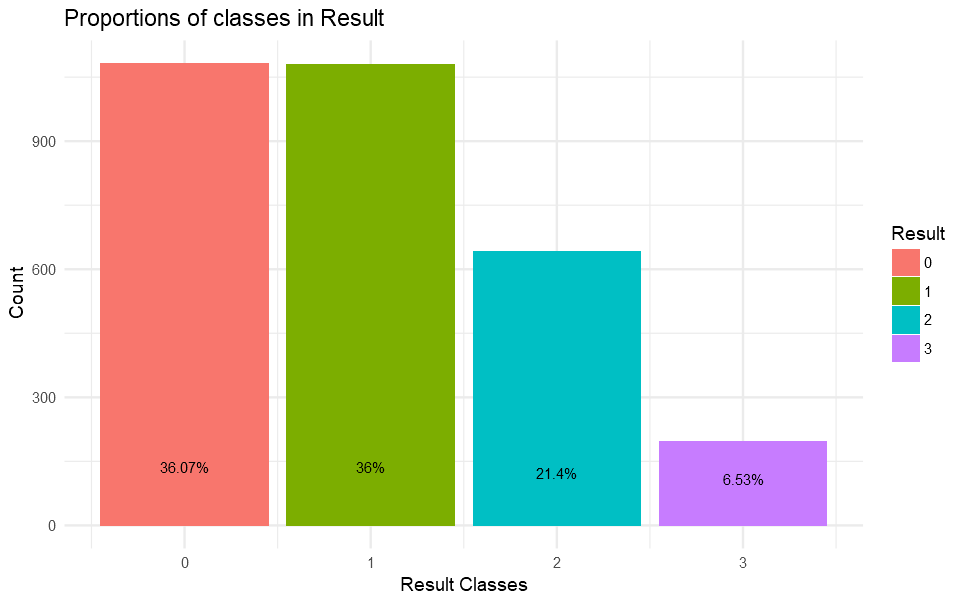

In [103]:
options(repr.plot.width=8, repr.plot.height=5)

class.props <- ggplot(data, aes(x=Result, fill=as.factor(Result))) + 
                    geom_bar(aes(y=..count..)) +
                    geom_text(aes(y = prop.table(..count..) * 100 + 100,
                                  label = paste0(round(prop.table(..count..),4) * 100, '%')), 
                              stat = 'count', position = position_dodge(.9), size = 3) + 
                    labs(x='Result Classes', y='Count', title='Proportions of classes in Result',fill='Result') +
                    theme_minimal()
class.props

**Principle Component Analysis**<br>
PCA describes complex data with fewer variables. The first component, PC1, is the direction where there is greatest variation in the data. PC2 is the maximum variation left in the data that is orthogonal to PC1. The PCA plot shows distinct clusters of the 4 classes, with little overlap.

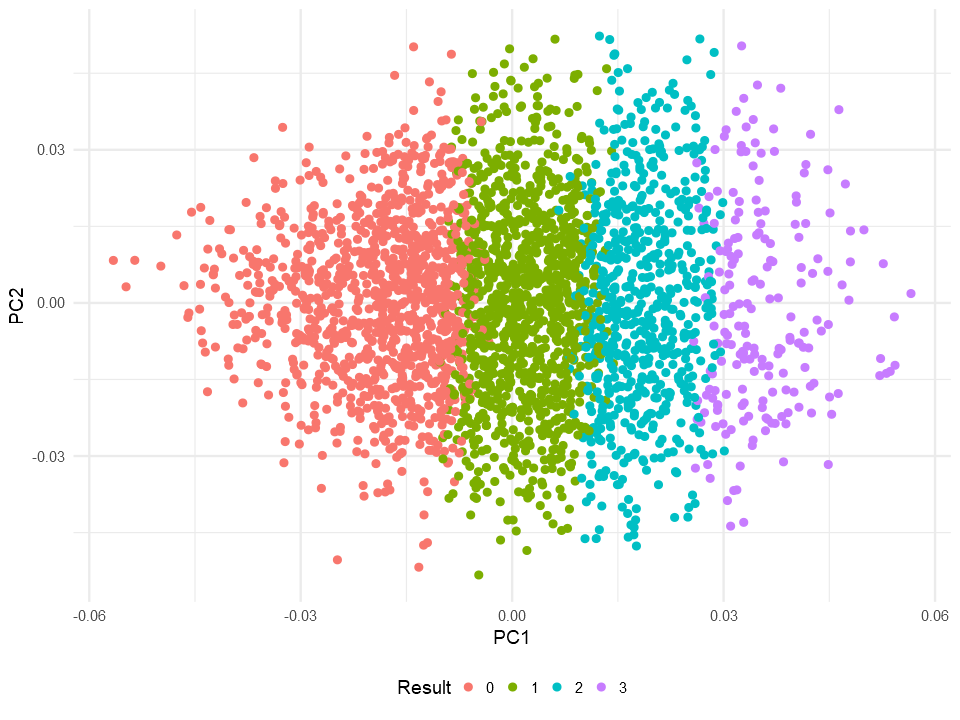

In [104]:
options(repr.plot.width=8, repr.plot.height=6)

data.r.pca <- prcomp(data.r[-11],
                 center = TRUE,
                 scale. = TRUE) 

# set Result as factor for coloring
data.r$Result <- as.factor(data.r$Result)

library(ggfortify)
autoplot(data.r.pca, data = data.r, colour = 'Result') + theme_minimal() + theme(legend.position = 'bottom')

**Boxplot**<br>
From the boxplot, the distribution of each class is quite distinct. Class 0(which is curable) tend to have lower values, whereas class 3(incurable) generaly have higher values.

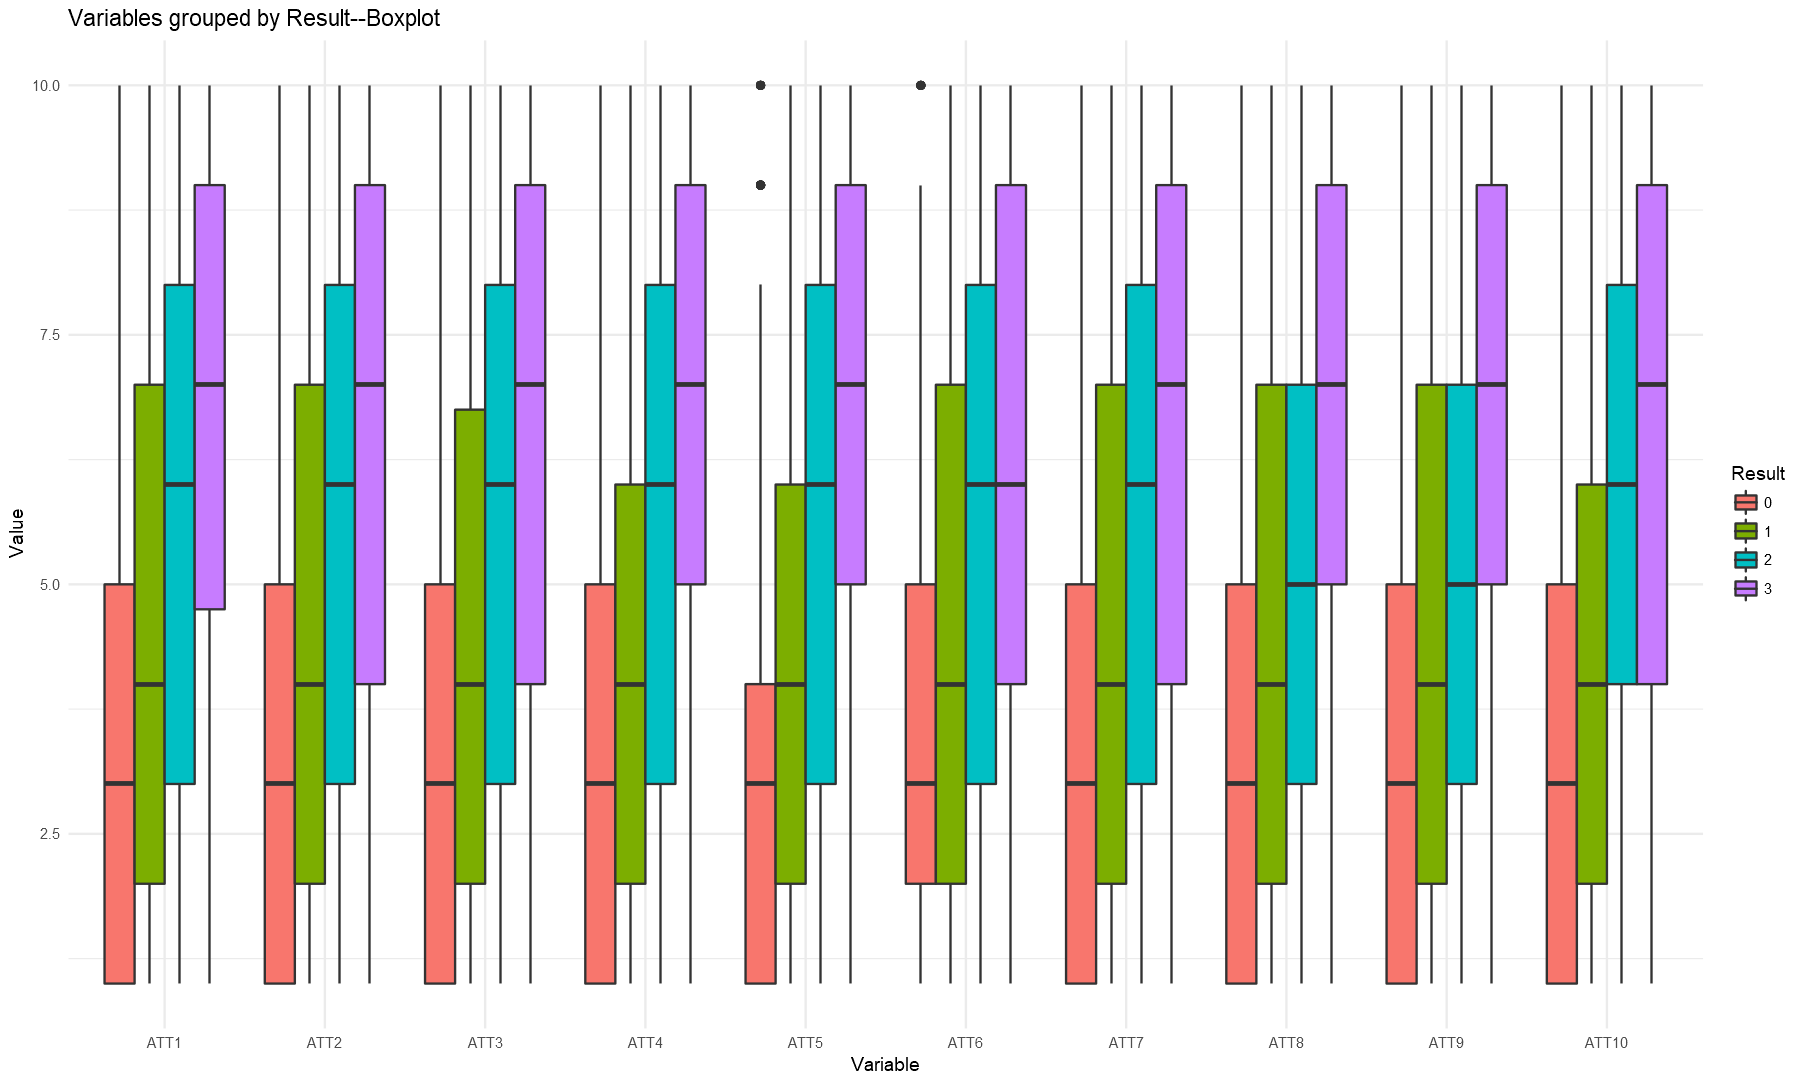

In [105]:
options(repr.plot.width=15, repr.plot.height=9)

#train.m <- melt(train)
data.r.m <- melt(data.r, id='Result')

ggplot(data.r.m, aes(x=variable,y=value)) + 
    geom_boxplot(aes(fill=Result)) + 
    theme_minimal() +
    labs(title='Variables grouped by Result--Boxplot', x='Variable', y='Value', fill='Result')

**Correlation Plot**<Br>
    There seems to be very little correlation between `ATT1 to ATT10`. However, `ATT1 to ATT10` all have a positive correlation to `Result`.

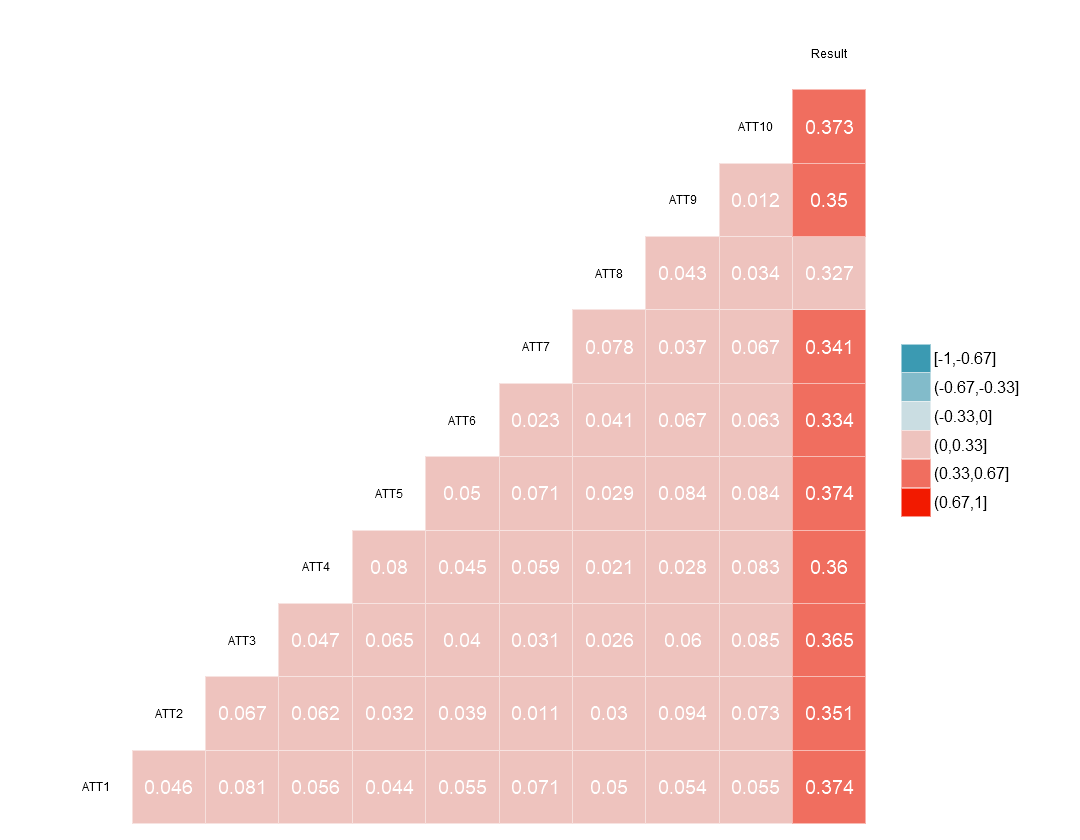

In [106]:
options(repr.plot.width=9, repr.plot.height=7)

data.r$Result<- as.numeric(as.character(data.r$Result))

ggcorr(data.r, label = TRUE, nbreaks = 6,label_color = "white",
       label_round = 3,size = 2.5, hjust =0.5)

## 4 Imputation
In this task, we will try three models -- linear regression, linear regression with ridge regularization and linear regression with lasso regularization. First, the dataset will be split in to 80% train and 20% test. We will choose the model that has the lowest RMSE, and use it to predict the missing values.

**Plot of Missing Data**<br>
Here we visualize the missing data. It seems like the missingness in the data is at random, as we cannot spot any obvious patterns. Therefore, we can use linear regression to predict the missing values and perform imputations.

Warning message in plot.aggr(res, ...):
"not enough horizontal space to display frequencies"

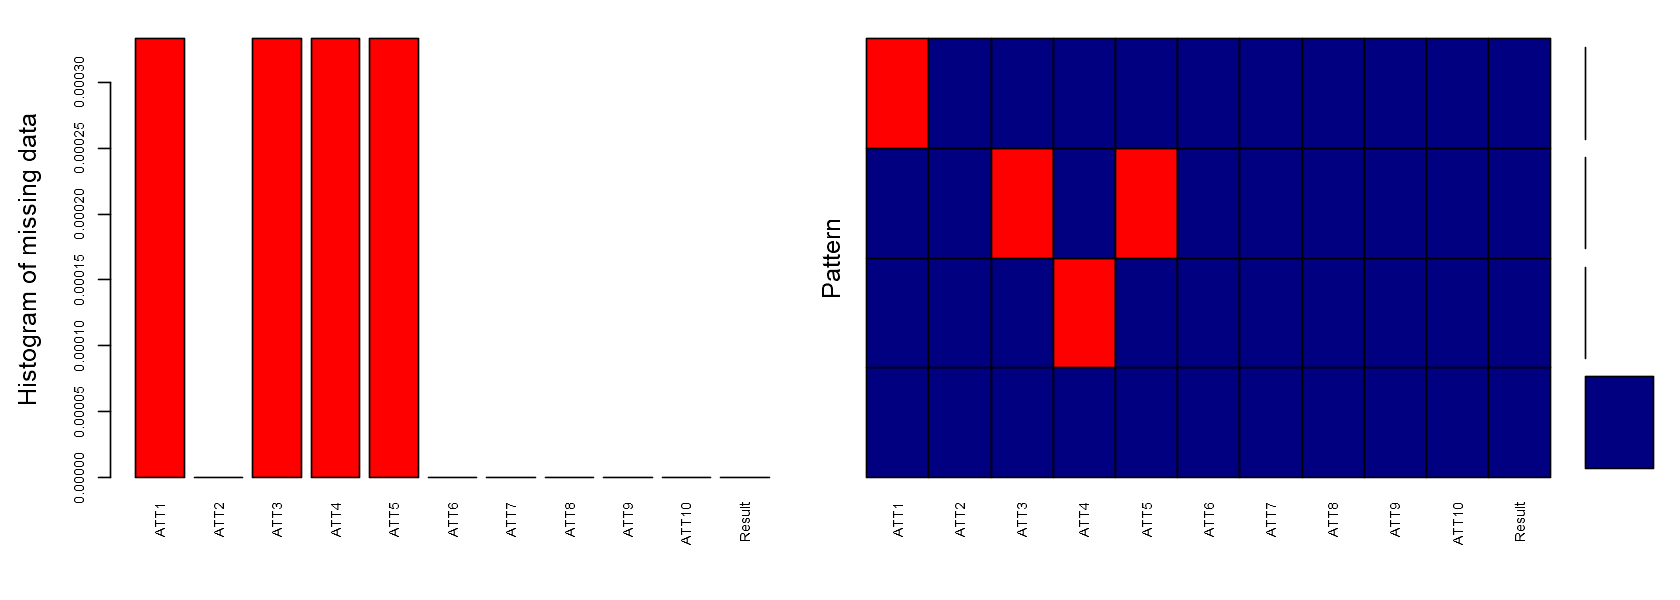

In [107]:
options(repr.plot.width=14, repr.plot.height=5)

aggr_plot <- aggr(data, col=c('navyblue','red'), numbers=TRUE, labels=names(data), 
                  cex.axis=.7, gap=3, ylab=c("Histogram of missing data","Pattern"))

**Function for spliting data into 80% train, 20% test**

In [108]:
split <- function(df, seed=123){
    set.seed(seed)
    train <- df %>% sample_frac(.8)
    test <- dplyr::setdiff(df, train)
    return(list('train.set'=train, 'test.set'=test))
}

**Function that returns RMSE of models and the predicted impute**

In [109]:
fit <- function(df, target, response='rmse', model='ridge', impute.row=NULL, seed=123){
    # change target name
    setnames(df, target, 'Target')
    
    # first split into 80% train, 20% test
    df.split <- split(df, seed)
    train <- df.split$train.set
    test <- df.split$test.set
    
    set.seed(seed)

    # create model matrix
    xmat <- model.matrix(Target~., data=train)[,-1]
    test.mat <- model.matrix(Target~., data=test)[,-1]
    
    ##### ridge #####       
    # find best lambda with CV
    cv.ridge <- cv.glmnet(xmat, train$Target, alpha = 0)
    bestlam.ridge <- cv.ridge$lambda.min
    # fit model
    fit.ridge <- glmnet(xmat, train$Target, alpha = 0)
    # predict test set with best lambda
    predicted.ridge <- predict(fit.ridge, s = bestlam.ridge, newx = test.mat)
    # RMSE
    rmse.ridge <- sqrt(mean((test$Target-predicted.ridge)^2))

    ##### lasso #####  
    # find best lambda with CV
    cv.lasso <- cv.glmnet(xmat, train$Target, alpha = 1)
    bestlam.lasso <- cv.lasso$lambda.min    
    # fit model
    fit.lasso <- glmnet(xmat, train$Target, alpha = 1)
    # predict test set with best lambda
    predicted.lasso <- predict(fit.lasso, s = bestlam.lasso, newx = test.mat)
    # RMSE
    rmse.lasso <- sqrt(mean((test$Target-predicted.lasso)^2))
   
    ##### lm #####
    fit.lm <- lm(train$Target~., data=train)
    predicted.lm <- predict(fit.lm, test)
    rmse.lm <- sqrt(mean((test$Target-predicted.lm)^2))
    
    # change back col name
    setnames(df, 'Target', target)
    
    if(response=='rmse'){
        error.all <- data.frame('type'=c("lm","ridge","lasso"), 'RMSE'=rep(0,3))
        error.all[error.all$type=='lm','RMSE'] <- rmse.lm
        error.all[error.all$type=='ridge','RMSE'] <- rmse.ridge
        error.all[error.all$type=='lasso','RMSE'] <- rmse.lasso
        
        
        return(list('rmse'=error.all[order(error.all$RMSE),], 'ridge'= fit.ridge, 'lasso' = fit.lasso, 'lm'=fit.lm))
    }
    
    if(response=='predict'){
        setnames(impute.row, target, 'Target')
        if(model=='ridge'){
            pred.mat <- t(model.matrix(Target~.,model.frame(Target~., impute.row, na.action=na.pass))[,-1])
            # change back name
            setnames(impute.row, 'Target', target)
            
            return(predict(fit.ridge, s = bestlam.lasso, newx = pred.mat))
        }
        if(model=='lasso'){
            pred.mat <- t(model.matrix(Target~.,model.frame(Target~., impute.row, na.action=na.pass))[,-1])
            # change back name
            setnames(impute.row, 'Target', target)
            
            return(predict(fit.lasso, s = bestlam.lasso, newx = pred.mat))
        }
        if(model=='lm'){
            # copy
            impute.row2 <- impute.row
            # change back name
            setnames(impute.row, 'Target', target)
            return(predict(fit.lm, impute.row2))
            
        }
    }
}

### 4.1 ATT1

**Find best model for ATT1**

In [110]:
results <- fit(data.r, 'ATT1', seed=2, response='rmse')$rmse
cat("Best Model for ATT1:", toString(results[1,1]), '-- with a RMSE of', toString(results[1,2]))

results

Best Model for ATT1: lasso -- with a RMSE of 2.27523627244799

,type,RMSE
3,lasso,2.275236
1,lm,2.275291
2,ridge,2.298773


**Predict ATT1 with Lasso**

In [111]:
predict.att1 <- fit(data.r, 'ATT1', seed=2, response='predict', model='lasso',impute.row=removed[1, ])
cat("The predicted value for ATT1 is: ", toString(predict.att1[1,1]), "\n")
cat("Rounding to the nearest integer: ", toString(round(predict.att1[1,1],0)))

The predicted value for ATT1 is:  6.29421123444967 
Rounding to the nearest integer:  6

**Impute ATT1**

In [112]:
removed[1,'ATT1'] <- 6

# check
removed

ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
6,8,9,1,1,1,1,5,6,1,1
10,7,NA,7,NA,5,2,7,1,1,2
3,4,3,NA,2,8,4,6,7,2,1


### 4.2 ATT3
Because the row that we need to impute ATT3 also has a missing ATT5. Therefore, for ATT3 we need to use the following formula:<br><br>
`ATT3~ATT1+ATT2+ATT4+ATT6+ATT7+ATT8+ATT9+ATT10+Result` <br>-- *notice that `ATT5` is excluded*

In [113]:
# create a subset of 'data.r' and 'removed' that does not contain ATT5
data.sub <- data.r[-5]
removed.sub <- removed[-5]

# check
cat("Subsetted 'data.r' dataframe for training the model\n")
head(data.sub)
cat("Subsetted 'removed' dataframe\n")
head(removed.sub)

Subsetted 'data.r' dataframe for training the model


,ATT1,ATT2,ATT3,ATT4,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,4,1,4,7,1,2,6,8,0
5,3,5,2,1,5,3,1,7,1,0
6,2,7,3,2,4,10,3,9,5,1
7,1,1,3,5,3,7,1,10,7,1
8,8,5,2,6,7,3,6,7,3,1
9,2,9,2,1,6,8,8,4,3,1


Subsetted 'removed' dataframe


ATT1,ATT2,ATT3,ATT4,ATT6,ATT7,ATT8,ATT9,ATT10,Result
6,8,9,1,1,1,5,6,1,1
10,7,NA,7,5,2,7,1,1,2
3,4,3,NA,8,4,6,7,2,1


**Find best model for ATT3**

In [114]:
results <- fit(data.sub, 'ATT3', seed=49, response='rmse')$rmse
cat("Best Model for ATT3:", toString(results[1,1]), '-- with a RMSE of', toString(results[1,2]))

results

Best Model for ATT3: lasso -- with a RMSE of 2.31712386400263

,type,RMSE
3,lasso,2.317124
1,lm,2.317186
2,ridge,2.326441


**Predict ATT3 with Lasso**

In [115]:
predict.att3 <- fit(data.sub, 'ATT3', seed=49, response='predict', model='lasso',impute.row=removed.sub[2, ])
cat("The predicted value for ATT3 is: ", toString(predict.att3[1,1]), "\n")
cat("Rounding to the nearest integer: ", toString(round(predict.att3[1,1],0)))

The predicted value for ATT3 is:  6.15673855292348 
Rounding to the nearest integer:  6

**Impute ATT3**

In [116]:
removed[2,'ATT3'] <- 6

# check
removed

ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
6,8,9,1,1,1,1,5,6,1,1
10,7,6,7,NA,5,2,7,1,1,2
3,4,3,NA,2,8,4,6,7,2,1


### 4.3 ATT5

**Find best model for ATT5**

In [117]:
results <- fit(data.r, 'ATT5', seed=99, response='rmse')$rmse
cat("Best Model for ATT5 is:", toString(results[1,1]), '-- with a RMSE of', toString(results[1,2]))

results

Best Model for ATT5 is: lasso -- with a RMSE of 2.16012883871237

,type,RMSE
3,lasso,2.160129
1,lm,2.160937
2,ridge,2.164399


**Predict ATT5 with Lasso**

In [118]:
predict.att5 <- fit(data.r, 'ATT5', seed=99, response='predict', model='lasso',impute.row=removed[2, ])
cat("The predicted value for ATT5 is: ", toString(predict.att5[1,1]), "\n")
cat("Rounding to the nearest integer: ", toString(round(predict.att5[1,1],0)))

The predicted value for ATT5 is:  5.96396972440377 
Rounding to the nearest integer:  6

**Impute ATT5**

In [119]:
removed[2,'ATT5'] <- 6

# check
removed

ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
6,8,9,1,1,1,1,5,6,1,1
10,7,6,7,6,5,2,7,1,1,2
3,4,3,NA,2,8,4,6,7,2,1


### 4.4 ATT4

**Find best model for ATT4**

In [120]:
results <- fit(data.r, 'ATT4', seed=13, response='rmse')$rmse
cat("Best Model for ATT4 is:", toString(results[1,1]), '-- with a RMSE of', toString(results[1,2]))

results

Best Model for ATT4 is: lasso -- with a RMSE of 2.31285784775898

,type,RMSE
3,lasso,2.312858
1,lm,2.313706
2,ridge,2.316408


**Predict ATT4 with Lasso**

In [121]:
predict.att4 <- fit(data.r, 'ATT4', seed=13, response='predict', model='lasso',impute.row=removed[3, ])
cat("The predicted value for ATT4 is: ", toString(predict.att4[1,1]), "\n")
cat("Rounding to the nearest integer: ", toString(round(predict.att4[1,1],0)))

The predicted value for ATT4 is:  4.56516659332047 
Rounding to the nearest integer:  5

**Impute ATT4**

In [122]:
removed[3,'ATT4'] <- 5

# check
removed

ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
6,8,9,1,1,1,1,5,6,1,1
10,7,6,7,6,5,2,7,1,1,2
3,4,3,5,2,8,4,6,7,2,1


### 4.5 Combine
Now that we have imputed all the missing values in `removed`,we will row bind `removed` to `data.r`, and call this dataframe `data.final`

In [123]:
data.final <- rbind(data.r, removed)

# check dim(should be 3000 rows)
cat("Dimension of data.final")
dim(data.final)

# view head
head(data.final)

Dimension of data.final

[1] 3000   11

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,4,1,4,3,7,1,2,6,8,0
5,3,5,2,1,6,5,3,1,7,1,0
6,2,7,3,2,1,4,10,3,9,5,1
7,1,1,3,5,9,3,7,1,10,7,1
8,8,5,2,6,2,7,3,6,7,3,1
9,2,9,2,1,4,6,8,8,4,3,1


## 5. Classification
In this section, we will try three different types of classification methods. They are the following:
* SVM
    * Radial Kernal
    * Linear Kernal
    * Polynomial Kernal
* Trees
    * Single trees
        * Tree with default values
        * Tree with low `cp` value
        * Pruned Tree
    * Ensemble Methods for Trees
        * Bagging
        * Random Forest
* K-Nearest Neighbor

We will compare each of the methods and choose the best one.

**Function for returning Accuracy**

In [124]:
acc <- function(predicted, true){
    return(100-mean(predicted!=true)*100)
}

**Split `data.final` into 80% train, 20% test**

In [125]:
# first split into train and test sets
data.final$Result <- as.factor(data.final$Result)
splitted <- split(data.final, seed=79)
train <- splitted$train.set
test <- splitted$test.set

dim(train)
dim(test)

[1] 2400   11

[1] 600  11

**Unbalanced Classes**<br>
* Effects of unbalanced classes in classification
> From our exploratory analysis, we know that this dataset has heavily unbalanced classes. This unbalance of classes is also present in the training and testing set. Adverse effects of this includes:
> * May cause our classifiers to be more biased towards the majority class labels
> * Cannot just rely on traditional classification accuracy.
>    * Example: Suppose we have to classes, A(90%) and B(10%), we can see that B is heavily under-represented. If the classifier happens to classify all testing points as class A, it will still have an accuracy of 90% -- even though it has failed in correctly classifying any instances of B.

* Ways of dealing with unbalanced classes<br>
Collecting more data is always the most obvious choice, however, in our situation, it is currently not possible. Thus we will need to explore other options.
> **1) Oversampling and Undersampling**<br>
This concept is fairly simple, for the minority classes we will *oversample* them, i.e. add copies of instances from the minor class. This is also known as sampling with replacement. For the over-represented classes, we will *undersample*, meaning to delete instances from them. If the dataset is fairly large, undersampling would probably be better, vice versa for smaller datasets. <br><br>
> **2) SMOTE**<br>
> SMOTE stands for "Synthetic Minority Over-sampling Technique". SMOTE oversamples by creating synthetic samples for the under-representated class instead of creating copies.<br><br>
> **3) Weights**<br>
> Instead of using the above sampling methods, we can add weights to each of the classes. This way, we penalize our classifier more if it wrongly classifies an instance of the minority class. <br><br> 
> **4) Performance Metric**<br>
Just reporting the accuract can be very misleading when we are dealing with unbalanced datasets. So we will need to look at other metrics such as:
> * Kappa Score: Takes into account the prediction performance of smaller classes
> * F1 Score: Balances *precision* and *recall*. In our multiclass case, we can *macro-average* (calculate F1 for every class and average it) the F1 score. We use macro-average instead of micro-average because micro-average gives *equal weight to each individial decision*, thus large classes will shadow the smaller classes. Whereas, macro-averaging gives us a sense of the classifier's effectiveness on small classes. (Manning et al., 2008)

For this assignment, we will use the 4th method mentioned above to deal with effects of having unbalanced classes.

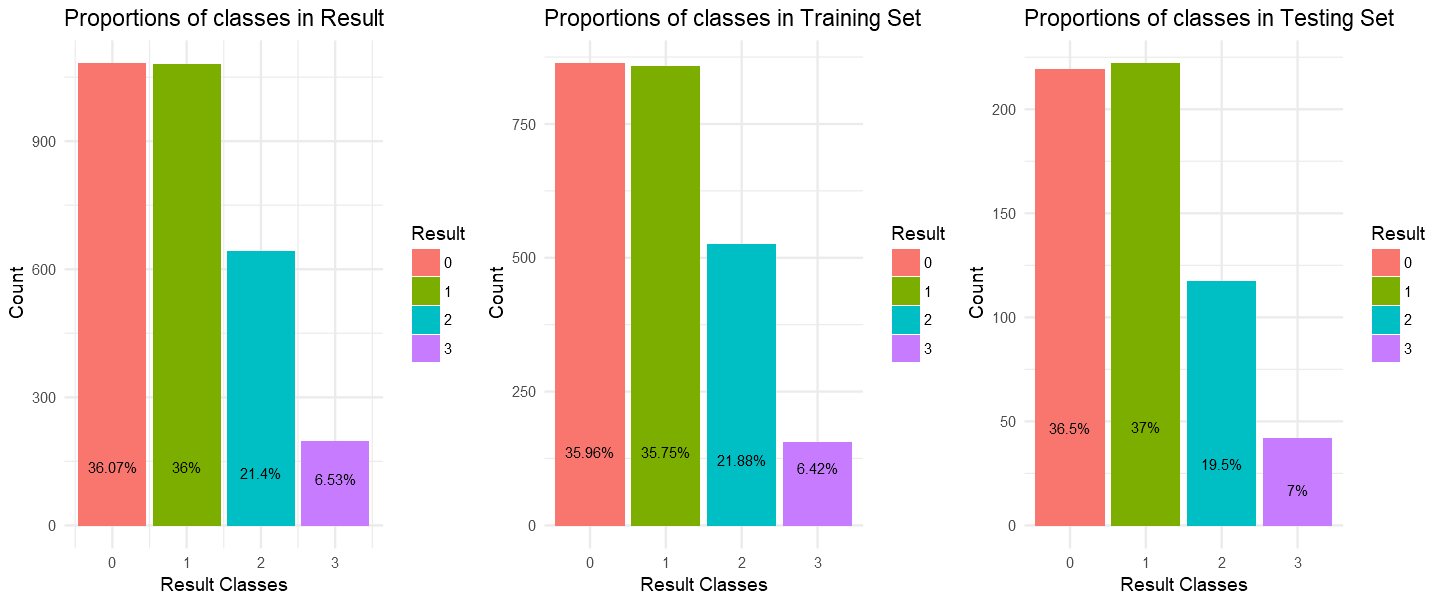

In [126]:
# proportions of classes
options(repr.plot.width=12, repr.plot.height=5)

train.props <- ggplot(train, aes(x=Result, fill=as.factor(Result))) + 
                geom_bar(aes(y=..count..)) +
                geom_text(aes(y = prop.table(..count..) * 100 + 100,
                              label = paste0(round(prop.table(..count..),4) * 100, '%')), 
                          stat = 'count', position = position_dodge(.9), size = 3) + 
                labs(x='Result Classes', y='Count', title='Proportions of classes in Training Set',fill='Result') +
                theme_minimal()
test.props <- ggplot(test, aes(x=Result, fill=as.factor(Result))) + 
                geom_bar(aes(y=..count..)) +
                geom_text(aes(y = prop.table(..count..) * 100 + 10,
                              label = paste0(round(prop.table(..count..),4) * 100, '%')), 
                          stat = 'count', position = position_dodge(.9), size = 3) + 
                labs(x='Result Classes', y='Count', title='Proportions of classes in Testing Set',fill='Result') +
                theme_minimal()

grid.arrange(class.props,train.props,test.props,ncol=3)

### 5.1 Support Vector Machines (SVM)
Here, we will use the package `e1071`. We will try out three different kernels(radial, linear, polynomial) for SVM. <br><br>
There are a few parameters that we can tune our SVM with. They are the following:
* `cost`
> The cost of classification, a parameter of the *soft-margin cost function*. `cost` controls the influence of individual points(i.e., how much we penalize the data points within the margin), it is essentially trading error penalty for stability.<br><br>
    * Higher `cost`: aims at classifying training points correctly, thus the margin is made narrower. This results in less data points in the margin, hence a lower number of support vectos. A higher `cost` will result in *lower bias(since we penalize the cost of misclassification) and higher variance*
    * Lower `cost`: creates a smoother decision boundary. A lower `cost` will result in *higher bias and lower variance* and more support vectors.
    
    
* `gamma`
> Defines how *far* the influence of a single training example reaches. If `gamma` has a low value, it means that every point has a *far reach*, and vice versa. So if we have a low `gamma`, points that are far away are also taken into consideration when drawing the decision boundary. Therefore, high value `gamma` are more likely to have wiggly boundaries.
   
   
* `degree`
> Only the polynomail kernel has this parameter.

All the tuning will be done with 10-fold cross validation.

<div class="alert alert-block alert-info">**a) Radial Kernel**</div>


In [127]:
# list of parameters
set.seed(39)
costs <- c(0.1, 1, 5, 10, 100)
gammas<- c(0.5, 1, 2)

# tune
tune.radial <- tune(svm, Result~., data=train, kernel='radial', ranges=list(cost=costs, gamma=gammas))

summary(tune.radial)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    5   0.5

- best performance: 0.18375 

- Detailed performance results:
    cost gamma     error dispersion
1    0.1   0.5 0.5087500 0.05183552
2    1.0   0.5 0.1970833 0.02693514
3    5.0   0.5 0.1837500 0.02393165
4   10.0   0.5 0.1837500 0.02393165
5  100.0   0.5 0.1837500 0.02393165
6    0.1   1.0 0.6670833 0.03444052
7    1.0   1.0 0.3800000 0.03400935
8    5.0   1.0 0.3525000 0.03075691
9   10.0   1.0 0.3525000 0.03075691
10 100.0   1.0 0.3525000 0.03075691
11   0.1   2.0 0.6670833 0.03444052
12   1.0   2.0 0.4575000 0.05772834
13   5.0   2.0 0.4470833 0.05665747
14  10.0   2.0 0.4470833 0.05665747
15 100.0   2.0 0.4470833 0.05665747


In [128]:
cat("The best parameters for radial svm are:")
tune.radial$best.parameters

The best parameters for radial svm are:

,cost,gamma
3,5,0.5


In [129]:
# assign the best model to a variable
svm.radial <- tune.radial$best.model

summary(svm.radial)


Call:
best.tune(method = svm, train.x = Result ~ ., data = train, ranges = list(cost = costs, 
    gamma = gammas), kernel = "radial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  5 
      gamma:  0.5 

Number of Support Vectors:  2080

 ( 830 154 521 575 )


Number of Classes:  4 

Levels: 
 0 1 2 3




In [130]:
# training accuracy
pred.train <- predict(svm.radial, newdata=train)
acc.train <- acc(pred.train, train$Result)
cat("The training accuracy for the radial kernel is: ", toString(acc.train), "%")

# testing accuracy
pred.test <- predict(svm.radial, newdata=test)
acc.test <- acc(pred.test, test$Result)
cat("\nThe testing accuracy for the radial kernel is: ", toString(round(acc.test,2)), "%")

The training accuracy for the radial kernel is:  100 %
The testing accuracy for the radial kernel is:  78.67 %

In [131]:
cat("\n--- Radial Kernel ---\n")
confusionMatrix(pred.test, test$Result, mode="prec_recall")

cat("\nMacro-Averaged F1")
round(mean(t(confusionMatrix(pred.test, test$Result, mode="prec_recall")$byClass)[7,]),3)


--- Radial Kernel ---


Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 182  14   0   0
         1  37 196  33   3
         2   0  12  84  29
         3   0   0   0  10

Overall Statistics
                                          
               Accuracy : 0.7867          
                 95% CI : (0.7517, 0.8188)
    No Information Rate : 0.37            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6831          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Precision              0.9286   0.7286   0.6720  1.00000
Recall                 0.8311   0.8829   0.7179  0.23810
F1                     0.8771   0.7984   0.6942  0.38462
Prevalence             0.3650   0.3700   0.1950  0.07000
Detection Rate         0.3033   0.3267   0.1400  0.01667
Detection Prevalence   0.3267   0.4483   0.2083  0.01667
Balanced Accuracy      0.8


Macro-Averaged F1

[1] 0.689

The radial kernel only correctly predicted 10 instances of class 3 correctly in the testing set. Therefore, it's kappa score is only 0.6831. If we look at the balanced accuracy, it predicts classes 0 to 2 fairly well, but struggles to predict class 3 observations.

<div class="alert alert-block alert-info">**b) Linear Kernel**</div>


In [132]:
# list of parameters
set.seed(17)
costs <- c(0.1, 1, 5, 10, 100)
gammas<- c(0.01, 0.1,0.5, 1, 2)

# tune
tune.linear <- tune(svm, Result~., data=train, kernel='linear', ranges=list(cost=costs, gamma=gammas))

summary(tune.linear)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
   10  0.01

- best performance: 0.0004166667 

- Detailed performance results:
    cost gamma        error  dispersion
1    0.1  0.01 0.0204166667 0.010101720
2    1.0  0.01 0.0116666667 0.007027284
3    5.0  0.01 0.0012500000 0.002012691
4   10.0  0.01 0.0004166667 0.001317616
5  100.0  0.01 0.0004166667 0.001317616
6    0.1  0.10 0.0204166667 0.010101720
7    1.0  0.10 0.0116666667 0.007027284
8    5.0  0.10 0.0012500000 0.002012691
9   10.0  0.10 0.0004166667 0.001317616
10 100.0  0.10 0.0004166667 0.001317616
11   0.1  0.50 0.0204166667 0.010101720
12   1.0  0.50 0.0116666667 0.007027284
13   5.0  0.50 0.0012500000 0.002012691
14  10.0  0.50 0.0004166667 0.001317616
15 100.0  0.50 0.0004166667 0.001317616
16   0.1  1.00 0.0204166667 0.010101720
17   1.0  1.00 0.0116666667 0.007027284
18   5.0  1.00 0.0012500000 0.002012691
19  10.0  1.00 0.0004166667 0.001317616
20 100.0  1.00

In [133]:
cat("The best parameters for linear svm are:")
tune.linear$best.parameters

The best parameters for linear svm are:

,cost,gamma
4,10,0.01


In [134]:
# assign the best model to a variable
svm.linear <- tune.linear$best.model

summary(svm.linear)


Call:
best.tune(method = svm, train.x = Result ~ ., data = train, ranges = list(cost = costs, 
    gamma = gammas), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 
      gamma:  0.01 

Number of Support Vectors:  352

 ( 159 34 94 65 )


Number of Classes:  4 

Levels: 
 0 1 2 3




In [135]:
# training accuracy
pred.train <- predict(svm.linear, newdata=train)
acc.train <- acc(pred.train, train$Result)
cat("The training accuracy for the linear kernel is: ", toString(round(acc.train,2)), "%")

# testing accuracy
pred.test <- predict(svm.linear, newdata=test)
acc.test <- acc(pred.test, test$Result)
cat("\nThe testing accuracy for the linear kernel is: ", toString(acc.test), "%")

The training accuracy for the linear kernel is:  99.96 %
The testing accuracy for the linear kernel is:  100 %

In [136]:
cat("\n--- Linear Kernel ---\n")
confusionMatrix(pred.test, test$Result, mode="prec_recall")

cat("\nMacro-Averaged F1")
round(mean(t(confusionMatrix(pred.test, test$Result, mode="prec_recall")$byClass)[7,]),3)


--- Linear Kernel ---


Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 219   0   0   0
         1   0 222   0   0
         2   0   0 117   0
         3   0   0   0  42

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9939, 1)
    No Information Rate : 0.37       
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Precision               1.000     1.00    1.000     1.00
Recall                  1.000     1.00    1.000     1.00
F1                      1.000     1.00    1.000     1.00
Prevalence              0.365     0.37    0.195     0.07
Detection Rate          0.365     0.37    0.195     0.07
Detection Prevalence    0.365     0.37    0.195     0.07
Balanced Accuracy       1.000     1.00    1.000     1.00


Macro-Averaged F1

[1] 1

The linear kernal had near perfect scores on the training and testing set. It is the only method to correctly classify all instances of class 3, hence having a perfect kappa score of 1. Perhaps the dataset is fairly linearly seperable?

<div class="alert alert-block alert-info">**c) Polynomial Kernel**</div>


In [137]:
# list of parameters
set.seed(3)
costs <- c(0.1, 1, 5, 10, 100)
degrees <- c(2, 3, 4)

# tune
tune.polynomial <- tune(svm, Result~., data=train, kernel='polynomial', ranges=list(cost=costs, degree=degrees))

summary(tune.polynomial)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost degree
    5      3

- best performance: 0.1204167 

- Detailed performance results:
    cost degree     error dispersion
1    0.1      2 0.4437500 0.04200097
2    1.0      2 0.3016667 0.03113095
3    5.0      2 0.2612500 0.02791978
4   10.0      2 0.2541667 0.02742836
5  100.0      2 0.2466667 0.02559478
6    0.1      3 0.1979167 0.02258813
7    1.0      3 0.1275000 0.01844662
8    5.0      3 0.1204167 0.02173511
9   10.0      3 0.1220833 0.02553819
10 100.0      3 0.1216667 0.03066898
11   0.1      4 0.3866667 0.04216370
12   1.0      4 0.2508333 0.03720563
13   5.0      4 0.2325000 0.02845019
14  10.0      4 0.2291667 0.02742836
15 100.0      4 0.2520833 0.03180828


In [138]:
cat("The best parameters for polynomial svm are:")
tune.polynomial$best.parameters

The best parameters for polynomial svm are:

,cost,degree
8,5,3


In [139]:
# assign the best model to a variable
svm.polynomial <- tune.polynomial$best.model

summary(svm.polynomial)


Call:
best.tune(method = svm, train.x = Result ~ ., data = train, ranges = list(cost = costs, 
    degree = degrees), kernel = "polynomial")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  5 
     degree:  3 
      gamma:  0.1 
     coef.0:  0 

Number of Support Vectors:  944

 ( 427 56 253 208 )


Number of Classes:  4 

Levels: 
 0 1 2 3




In [140]:
# training accuracy
pred.train <- predict(svm.polynomial, newdata=train)
acc.train <- acc(pred.train, train$Result)
cat("The training accuracy for the polynomial kernel is: ", toString(round(acc.train,2)), "%")

# testing accuracy
pred.test <- predict(svm.polynomial, newdata=test)
acc.test <- acc(pred.test, test$Result)
cat("\nThe testing accuracy for the polynomial kernel is: ", toString(round(acc.test,2)), "%")

The training accuracy for the polynomial kernel is:  96.25 %
The testing accuracy for the polynomial kernel is:  89 %

In [141]:
cat("\n--- Polynomial Kernel ---\n")
confusionMatrix(pred.test, test$Result, mode="prec_recall")

cat("\nMacro-Averaged F1")
round(mean(t(confusionMatrix(pred.test, test$Result, mode="prec_recall")$byClass)[7,]),3)


--- Polynomial Kernel ---


Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 203  17   0   0
         1  16 191  10   0
         2   0  14 100   2
         3   0   0   7  40

Overall Statistics
                                          
               Accuracy : 0.89            
                 95% CI : (0.8622, 0.9139)
    No Information Rate : 0.37            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8404          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Precision              0.9227   0.8802   0.8621  0.85106
Recall                 0.9269   0.8604   0.8547  0.95238
F1                     0.9248   0.8702   0.8584  0.89888
Prevalence             0.3650   0.3700   0.1950  0.07000
Detection Rate         0.3383   0.3183   0.1667  0.06667
Detection Prevalence   0.3667   0.3617   0.1933  0.07833
Balanced Accuracy      0.9


Macro-Averaged F1

[1] 0.888

Interestingly, we looking at the balanced accuracy of the polynomial kernel confusion matrix, class 1 had the lowest balanced accuracy when it was one of the majority classes in the dataset. Class 3, the minority, had the highest balanced accuracy. Even though the polynomial kernel had a fairly high kappa score of 0.8404, the training accuracy was far higher than testing accuracy, indicating that this model may be overfitting the data.

<div class="alert alert-block alert-info">**Summary of SVMs**</div>

All three kernels had near perfect training accuracy, however, radial and polynomial kernels had lower testing accuracy. This might indicate that they are overfitting the training set. From the kappa scores, it is evident that the radial kernel did not do a good job of predicting 
On the other hand, the linear kernel had near perfect scores on the training and testing dataset. This might suggest that our data is linear seperable

|Kernel Type|Parameters|Number of<br>Support Vectors|Training<br>Accuracy|Testing<br>Accuracy|Kappa<br>Score|Macro Avg. F1|
|-----------|----------|-----------------|----------------|--------------------------|----|---|---|
|Radial|cost = 5<br> gamma = 0.5|2080|100%|78.67%|0.6831|0.689|
|Linear|cost = 10<br> gamma = 0.01|352|99.96%|100%|1|1|
|Polynomial|cost = 5<br> degree = 3 <br>gamma = 0.1|944|96.25%|89%|0.8404|0.888|

### 5.2 Trees Based Methods

<div class="alert alert-block alert-info">**a) Single Trees**</div>
Here, we will try tree based methods to classify the data. We will start off by using single trees and tune the complexity parameter(`cp`). 

Complexity Parameters(`cp`)
> *From `rpart` resources: if any split does not increase the overall $R^2$ of the model by at least cp, then that split is decreed to be not worth pursuing. The program does not split said branch any further, and saves considerable computational effort.*

> So, if we set `cp=0.05`, it will only split a node if the relative error improvement is greater than `0.05`. So to find the best `cp`, we can set `cp` to a very small value, then call the `cptable` from the tree model, and select the `cp` where `rel_error + xstd < xerror`(cross validation error). This can also be done visually by using the function `plotcp()` on our tree model.<br><br>


We will first try a tree with the default `cp` value, then try another tree with a small `cp` value. Next, use the second tree and pruned it based on the best `cp`.

**a-1) Tree with default cp (`cp=0.01`)**

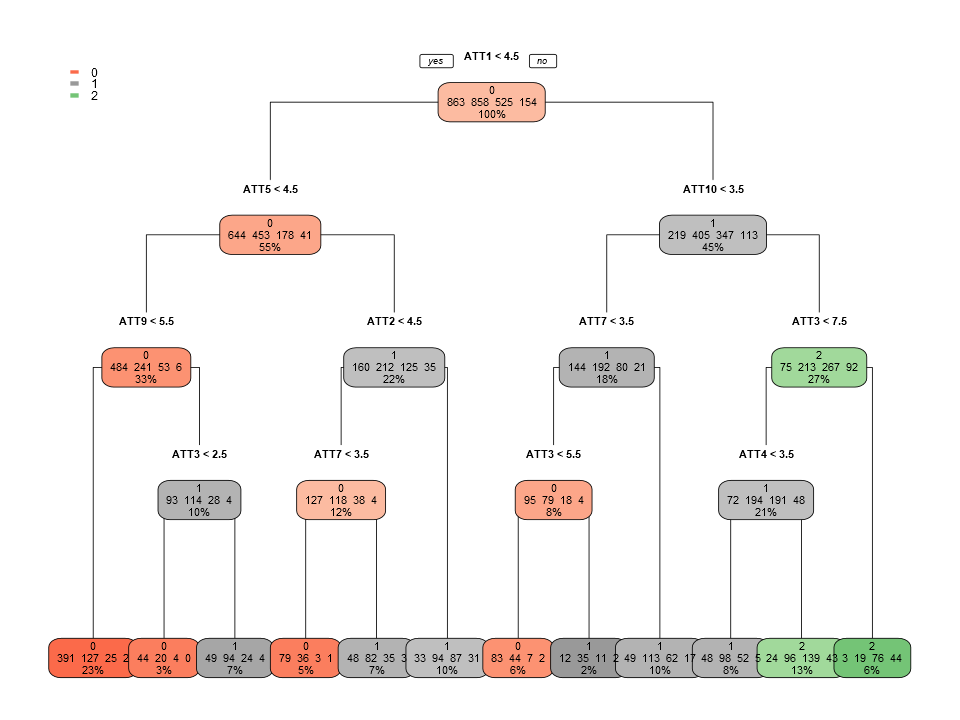

In [142]:
set.seed(56)

# tree with default cp
tree <- rpart(Result ~ ., data = train, method = 'class')

# plot tree
options(repr.plot.width=8, repr.plot.height=6)
rpart.plot(tree, type=1,compress=FALSE, ycompress=FALSE, cex=0.5, extra=101)

In [143]:
# training accuracy
pred.train <- predict(tree, train, type='class')
acc.train <- acc(pred.train, train$Result)
cat("The training accuracy for the tree is: ", toString(round(acc.train,2)), "%")

# testing accuracy
pred.test <- predict(tree, newdata=test, type='class')
acc.test <- acc(pred.test, test$Result)
cat("\nThe testing accuracy for the tree is: ", toString(round(acc.test,2)), "%")

The training accuracy for the tree is:  55.33 %
The testing accuracy for the tree is:  52 %

In [144]:
nodes <- as.numeric(rownames(tree$frame))

cat("Depth of tree:", toString(max(rpart:::tree.depth(nodes))))

Depth of tree: 4

In [145]:
cat("\n--- Tree with Default cp ---\n")
confusionMatrix(pred.test, test$Result, mode="prec_recall")

cat("\nMacro-Averaged F1")
round(mean(t(confusionMatrix(pred.test, test$Result, mode="prec_recall")$byClass)[7,]),3)


--- Tree with Default cp ---


Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 139  73  14   3
         1  70 127  57  16
         2  10  22  46  23
         3   0   0   0   0

Overall Statistics
                                          
               Accuracy : 0.52            
                 95% CI : (0.4792, 0.5606)
    No Information Rate : 0.37            
    P-Value [Acc > NIR] : 5.563e-14       
                                          
                  Kappa : 0.2742          
 Mcnemar's Test P-Value : 1.026e-10       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Precision              0.6070   0.4704  0.45545       NA
Recall                 0.6347   0.5721  0.39316     0.00
F1                     0.6205   0.5163  0.42202       NA
Prevalence             0.3650   0.3700  0.19500     0.07
Detection Rate         0.2317   0.2117  0.07667     0.00
Detection Prevalence   0.3817   0.4500  0.16833     0.00
Balanced Accuracy      0.6


Macro-Averaged F1

[1] NA

This tree has misclassified every instance of Class 3. The majority vote in each leaf node determines how we will predict for the the testing set. From the plot, we can also see that none of the leaves have class 3 as the majority, due the under-representation of class 3. Thus, the tree will never predict class 3 for any newcoming data. This is also confirmed by the confusion matrix. 

**a-2) Tree with low `cp`**

In [146]:
# tree model, notice the small value that we've assigned to cp
set.seed(73)

tree2 <- rpart(Result ~ ., data = train, control = rpart.control(cp = 0.0005))

In [147]:
# training accuracy
pred.train <- predict(tree2, train, type='class')
acc.train <- acc(pred.train, train$Result)
cat("The training accuracy for the tree is: ", toString(round(acc.train,2)), "%")

# testing accuracy
pred.test <- predict(tree2, newdata=test, type='class')
acc.test <- acc(pred.test, test$Result)
cat("\nThe testing accuracy for the tree is: ", toString(round(acc.test,2)), "%")

The training accuracy for the tree is:  76.75 %
The testing accuracy for the tree is:  57 %

In [148]:
nodes <- as.numeric(rownames(tree2$frame))

cat("Depth of tree:", toString(max(rpart:::tree.depth(nodes))))

Depth of tree: 12

In [149]:
cat("\n--- Tree with low cp ---\n")
confusionMatrix(pred.test, test$Result, mode="prec_recall")

cat("\nMacro-Averaged F1")
round(mean(t(confusionMatrix(pred.test, test$Result, mode="prec_recall")$byClass)[7,]),3)


--- Tree with low cp ---


Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 158  63   8   2
         1  55 122  47   7
         2   6  35  52  23
         3   0   2  10  10

Overall Statistics
                                        
               Accuracy : 0.57          
                 95% CI : (0.5293, 0.61)
    No Information Rate : 0.37          
    P-Value [Acc > NIR] : < 2e-16       
                                        
                  Kappa : 0.3646        
 Mcnemar's Test P-Value : 0.05202       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Precision              0.6840   0.5281  0.44828  0.45455
Recall                 0.7215   0.5495  0.44444  0.23810
F1                     0.7022   0.5386  0.44635  0.31250
Prevalence             0.3650   0.3700  0.19500  0.07000
Detection Rate         0.2633   0.2033  0.08667  0.01667
Detection Prevalence   0.3850   0.3850  0.19333  0.03667
Balanced Accuracy      0.7649   0.6306  0.


Macro-Averaged F1

[1] 0.5

Setting the `cp` to a smaller value improved scores as class 3 was able to become majority votes in the leaf nodes. However, the cost of this is that now our tree is too big. So, we will try to prune the tree with the optimal `cp`.

**Find optimal cp**<br>
The horizontal line represents the highest `rel_error + xstd` that is less than `xerror`. A good choice of `cp` for pruning is often the leftmost value for which the mean lies below the horizontal line (from `rpart` documentation).

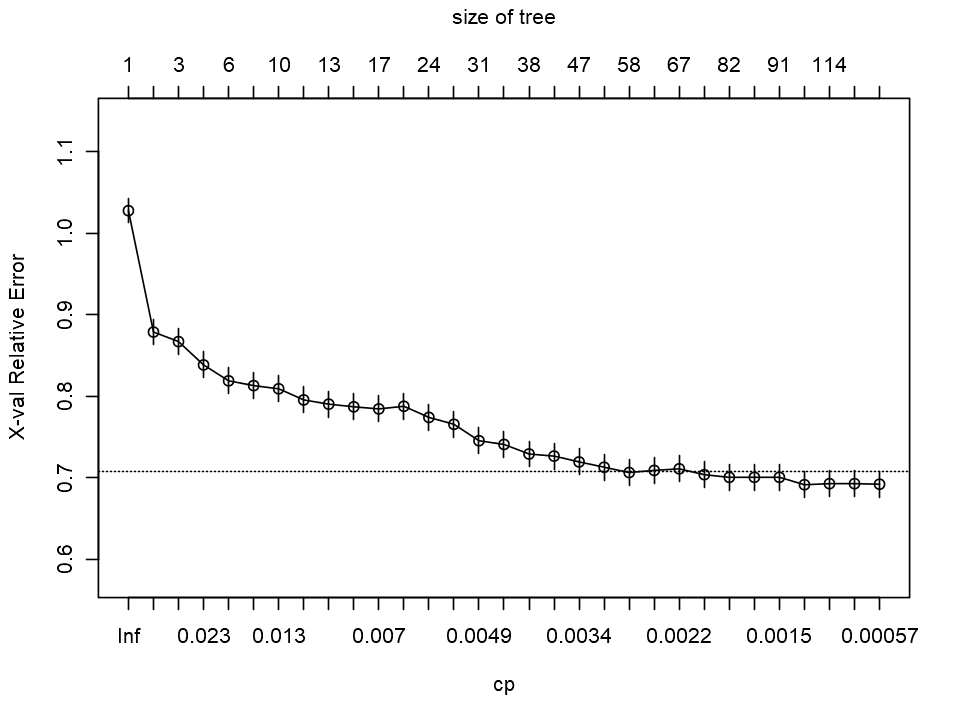

In [150]:
plotcp(tree2)

**a-3) Prune Tree with Best `cp`**

In [151]:
bestcp <- 0.002
tree.pruned <- prune(tree2, cp = bestcp)

In [152]:
# training accuracy
pred.train <- predict(tree.pruned, train, type='class')
acc.train <- acc(pred.train, train$Result)
cat("The training accuracy for the pruned tree is: ", toString(round(acc.train,2)), "%")

# testing accuracy
pred.test <- predict(tree.pruned, newdata=test, type='class')
acc.test <- acc(pred.test, test$Result)
cat("\nThe testing accuracy for the pruned tree is: ", toString(round(acc.test,2)), "%")

The training accuracy for the pruned tree is:  72.08 %
The testing accuracy for the pruned tree is:  55.33 %

In [153]:
nodes <- as.numeric(rownames(tree.pruned$frame))

cat("Depth of tree:", toString(max(rpart:::tree.depth(nodes))))

Depth of tree: 9

In [154]:
cat("\n--- Tree with Optimal cp ---\n")
confusionMatrix(pred.test, test$Result, mode="prec_recall")

cat("\nMacro-Averaged F1")
round(mean(t(confusionMatrix(pred.test, test$Result, mode="prec_recall")$byClass)[7,]),3)


--- Tree with Optimal cp ---


Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 145  59   5   1
         1  64 121  48   8
         2  10  41  57  24
         3   0   1   7   9

Overall Statistics
                                          
               Accuracy : 0.5533          
                 95% CI : (0.5125, 0.5936)
    No Information Rate : 0.37            
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.3419          
 Mcnemar's Test P-Value : 0.00578         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Precision              0.6905   0.5021   0.4318  0.52941
Recall                 0.6621   0.5450   0.4872  0.21429
F1                     0.6760   0.5227   0.4578  0.30508
Prevalence             0.3650   0.3700   0.1950  0.07000
Detection Rate         0.2417   0.2017   0.0950  0.01500
Detection Prevalence   0.3500   0.4017   0.2200  0.02833
Balanced Accuracy      0.7


Macro-Averaged F1

[1] 0.49

The pruned tree yielded scores better than the first tree with the default `cp`. However, it did perform slightly worse than the tree with low `cp`. Nevertheless, it is more acceptable than `tree2` because we get very similar scores but with a smaller tree.

<div class="alert alert-block alert-info">**Summary of Single Trees**</div>

|Tree|Depth|Training Accuracy|Testing Accuracy|Kappa Score|Macro Avg. F1|
|----|-----------------|----------------|-----------|-------------|
|Default Tree|4|55.33%|52%|0.2742|NA|
|Tree(low `cp`)|12|76.75%|57%|0.3646|0.5|
|Pruned Tree|9|72.08%|55.33%|0.3419|0.49|
<br><br>
Overall, single trees did not do well. Mainly due to the imbalanced classes, hence the trees have a difficult time classifying class 3. When the we lowered the `cp` value, some class 3 did make it to the leaf node, and accuracy scores improved slightly. The best single tree model we ended up was the pruned tree.<br><br>
Below are plots of variable importance in the three trees.<Br><br>
**Variable Importance in the single trees**<br>
When we have low `cp`, the importance of the varibles are all very similar. Whereas, with the default tree and pruned tree, the variable importance varies between each attribute

In [155]:
# get the variable importance values
tree.var <- melt(t(data.frame('tree'=tree$variable.importance)))
tree.cp.var <- melt(t(data.frame('tree.cp'=tree2$variable.importance)))
tree.pruned.var <- melt(t(data.frame('tree.pruned'=tree.pruned$variable.importance)))

# change column names
names(tree.var) <- c("tree.type", "att", "value")
names(tree.cp.var) <- c("tree.type", "att", "value")
names(tree.pruned.var) <- c("tree.type", "att", "value")

# remove factors
tree.var <- transform(tree.var, tree.type = as.character(tree.type), att = as.character(att))
tree.cp.var <- transform(tree.cp.var, tree.type = as.character(tree.type), att = as.character(att))
tree.pruned.var <- transform(tree.pruned.var, tree.type = as.character(tree.type), att = as.character(att))

**Plot**

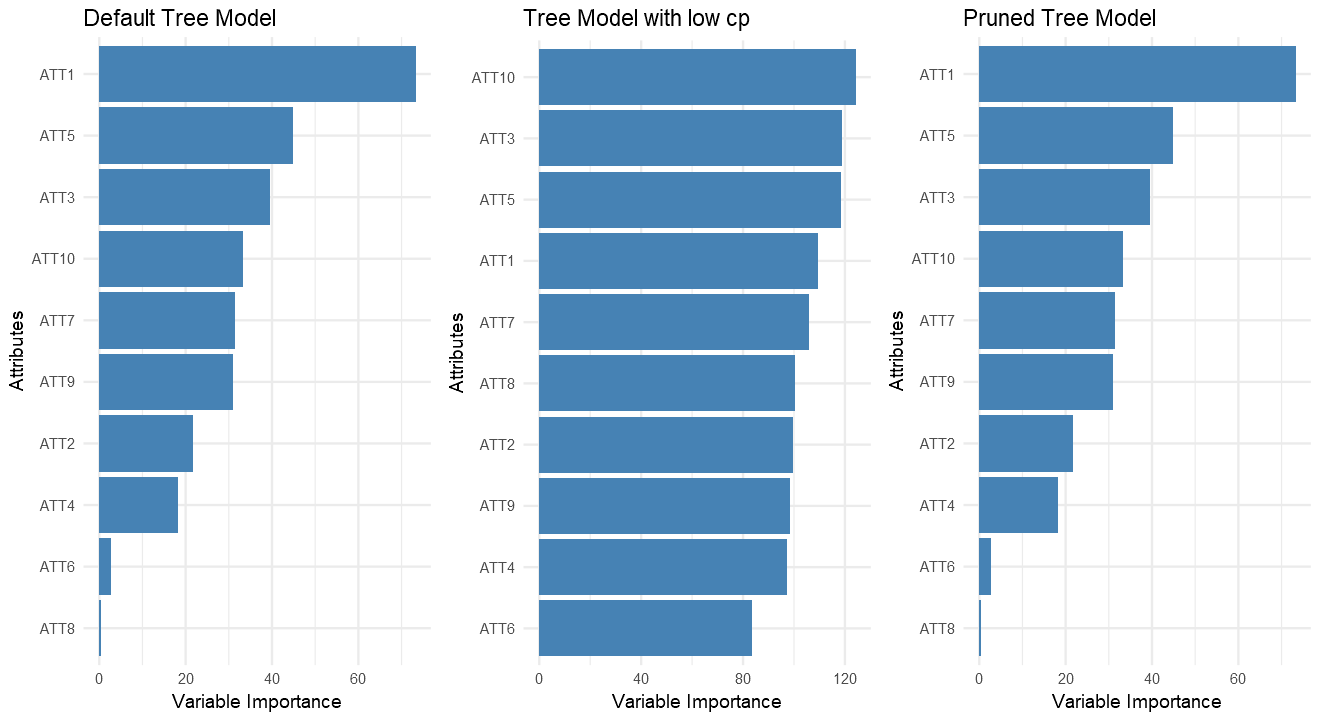

In [156]:
options(repr.plot.width=11, repr.plot.height=6)

tree.p <- ggplot(tree.var, aes(x=reorder(att, value), y=value)) + 
            geom_bar(stat='identity', fill="steelblue") + coord_flip() +
            labs(x='Attributes', y='Variable Importance', title='Default Tree Model') + theme_minimal()
tree.cp.p <- ggplot(tree.cp.var, aes(x=reorder(att, value), y=value, fill="steelblue")) + 
                geom_bar(stat='identity', fill="steelblue") + coord_flip() + 
                labs(x='Attributes', y='Variable Importance', title='Tree Model with low cp') + theme_minimal()
tree.pruned.p <- ggplot(tree.var, aes(x=reorder(att, value), y=value)) + 
                    geom_bar(stat='identity', fill="steelblue") + coord_flip() + 
                        labs(x='Attributes', y='Variable Importance', title='Pruned Tree Model') + theme_minimal()

# plot
grid.arrange(tree.p, tree.cp.p, tree.pruned.p, ncol=3)

<div class="alert alert-block alert-info">**b) Ensemble Methods for Trees**</div>

Ensemble methods combines multiple machine learning techniques into one predictive model. By doing this we can either reduce variance, bias or imporve our predictions, based on the ensemble methods we use. Here, we use bagging and random forests and compare how they perform.
<Br>
Difference between how bagging and random forests reduce variance:
> * Bagging<Br>
> Uses bootstrap to produce multiple training sets, and averages the outcome of multiple fully grown trees<Br><br>
> * Random Forest <br>
> Random selection of features to split nodes on reduces the correlation between the trees, therefore lowering the variance

Defining `OOB error rate`
> An internal error estimation that is calculated as we build the multiple trees, since each tree is trained on a subset of the training data and then tested on the the rest of the training data.

<br>
**b-1) Bagging**<br>
Bagging, also known as bootstrap aggregating, theoretically lowers variance in single fully grown *unpruned* decision trees. It does this by bootstrapping the training data, growing multiple trees and averaging the predictions. The main difference between bagging and random forests is that bagging considers *all* features when splitting a node, hence, we set `mtry = 10`.

In [157]:
set.seed(20)
tree.bagging <- randomForest(Result ~ ., train, mtry = 10, ntree = 1000, importance = TRUE)

print(tree.bagging)


Call:
 randomForest(formula = Result ~ ., data = train, mtry = 10, ntree = 1000,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 10

        OOB estimate of  error rate: 23.54%
Confusion matrix:
    0   1   2  3 class.error
0 760 103   0  0   0.1193511
1 111 703  44  0   0.1806527
2   0 194 328  3   0.3752381
3   0   3 107 44   0.7142857


In [158]:
# training accuracy
pred.train <- predict(tree.bagging, train, type='class')
acc.train <- acc(pred.train, train$Result)
cat("The training accuracy for the bagged tree is: ", toString(round(acc.train,2)), "%")

# testing accuracy
pred.test <- predict(tree.bagging, newdata=test, type='class')
acc.test <- acc(pred.test, test$Result)
cat("\nThe testing accuracy for the bagged tree is: ", toString(round(acc.test,2)), "%")

The training accuracy for the bagged tree is:  100 %
The testing accuracy for the bagged tree is:  74.17 %

In [159]:
cat("\n--- Bagged Trees ---\n")
confusionMatrix(pred.test, test$Result, mode="prec_recall")

cat("\nMacro-Averaged F1")
round(mean(t(confusionMatrix(pred.test, test$Result, mode="prec_recall")$byClass)[7,]),3)


--- Bagged Trees ---


Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 185  34   0   0
         1  34 181  49   0
         2   0   7  67  30
         3   0   0   1  12

Overall Statistics
                                          
               Accuracy : 0.7417          
                 95% CI : (0.7047, 0.7763)
    No Information Rate : 0.37            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6137          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Precision              0.8447   0.6856   0.6442  0.92308
Recall                 0.8447   0.8153   0.5726  0.28571
F1                     0.8447   0.7449   0.6063  0.43636
Prevalence             0.3650   0.3700   0.1950  0.07000
Detection Rate         0.3083   0.3017   0.1117  0.02000
Detection Prevalence   0.3650   0.4400   0.1733  0.02167
Balanced Accuracy      0.8


Macro-Averaged F1

[1] 0.658

 Bagging did not work as well as expected, this may be because it averages predictions from multiple tree, and since class 0 is the most common occurring class, it becomes highly biased will classified more observations as class 0.

**Plot of error rates**<br>
Here we plot the error rates of each class over the number of trees. As the number of trees increases, the error rates for classes 0 to 2 all decrease, however, the error rate of class 3 increases. This is, again, most likely due to the under-representation of this class.

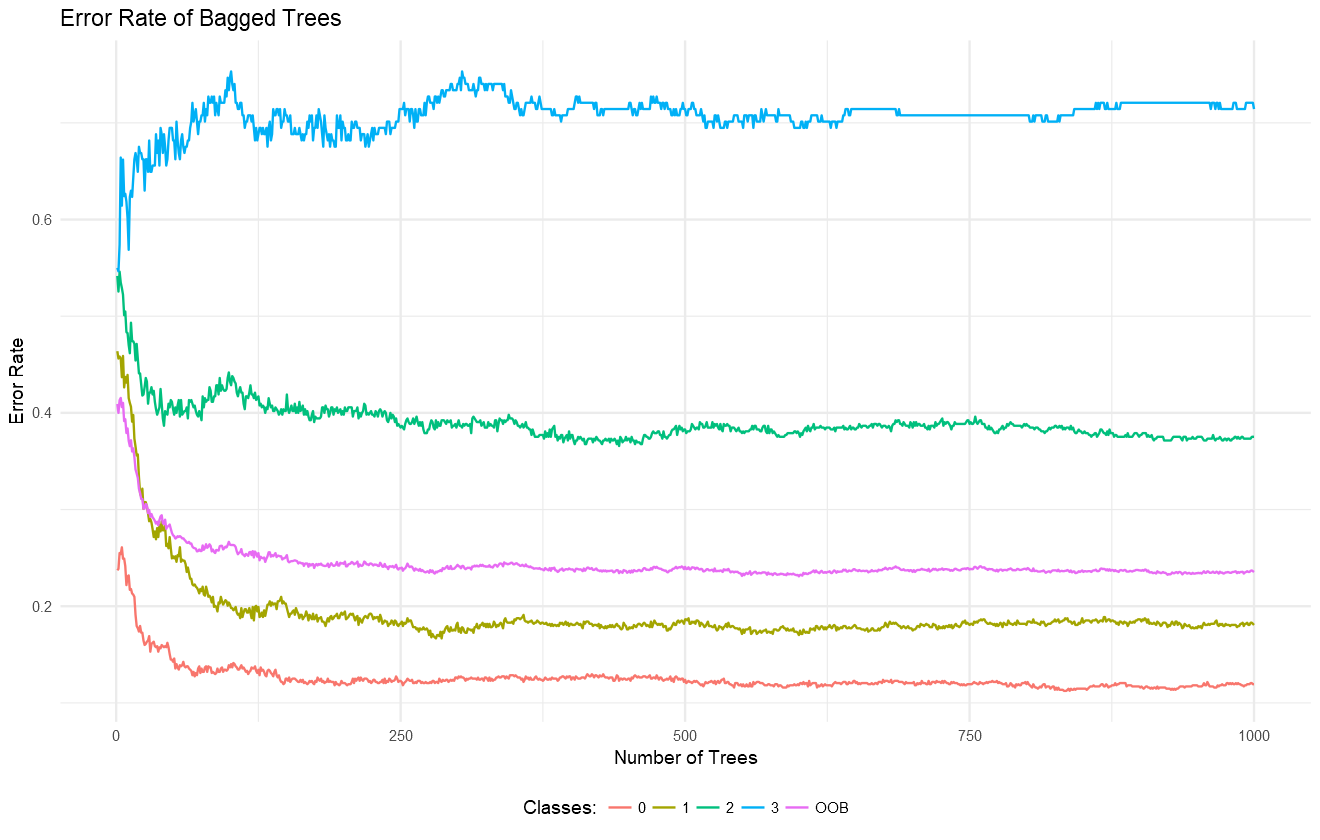

In [160]:
options(repr.plot.width=11, repr.plot.height=7)

# get the error rates from the bagged tree
bagging.error <- melt(tree.bagging$err.rate)

# rename columns
names(bagging.error) <- c("x", "variable", "value")

# plot
ggplot(bagging.error) + geom_line(aes(x=x, y=value, color = as.factor(variable))) + theme_minimal() + 
    labs(x="Number of Trees", y="Error Rate", title="Error Rate of Bagged Trees", color="Classes: ") +
    theme(legend.position = 'bottom')

**b-1) Random Forests**<Br>
We will use `tuneRF()` to find the best `mtry` value base on the out-of-bag error. A general starting point is to use $\sqrt(number of attributes)$, so we have set `mtryStart=3`.

mtry = 3  OOB error = 28.83% 
Searching left ...
mtry = 2 	OOB error = 26.46% 
0.08236994 0.05 
mtry = 1 	OOB error = 32.08% 
-0.2125984 0.05 
Searching right ...
mtry = 6 	OOB error = 27.5% 
-0.03937008 0.05 


,mtry,OOBError
1.OOB,1,0.3208333
2.OOB,2,0.2645833
3.OOB,3,0.2883333
6.OOB,6,0.2750000


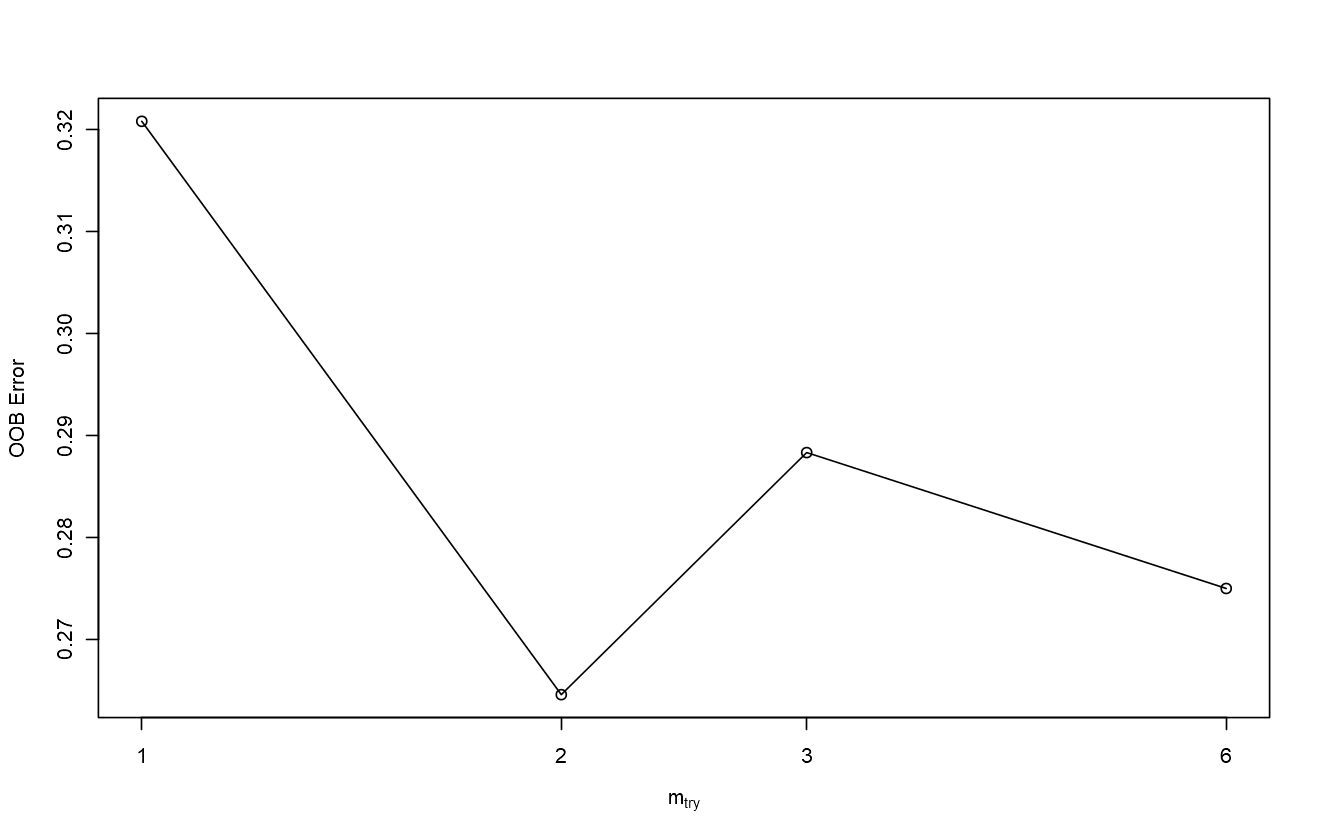

In [161]:
options(repr.plot.width=11, repr.plot.height=7)

set.seed(3)

tuneRF(train[-11], train$Result, mtryStart=3, stepFactor=2)

**Best value for `mtry` is 2**

In [162]:
set.seed(3)

tree.forest.2 <- randomForest(Result ~ ., train, mtry = 2, ntree = 1000, importance = TRUE)

cat("\n\n---------------------------- Random forest with 2 predictors (mtry=2) ----------------------------")
print(tree.forest.2)



---------------------------- Random forest with 2 predictors (mtry=2) ----------------------------
Call:
 randomForest(formula = Result ~ ., data = train, mtry = 2, ntree = 1000,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 21.88%
Confusion matrix:
    0   1   2  3 class.error
0 781  82   0  0  0.09501738
1  96 745  17  0  0.13170163
2   0 207 318  0  0.39428571
3   0   1 122 31  0.79870130


In [163]:
# training accuracy
pred.train <- predict(tree.forest.2, train, type='class')
acc.train <- acc(pred.train, train$Result)
cat("The training accuracy for the random forest is: ", toString(round(acc.train,2)), "%")

# testing accuracy
pred.test <- predict(tree.forest.2, newdata=test, type='class')
acc.test <- acc(pred.test, test$Result)
cat("\nThe testing accuracy for the random forest is: ", toString(round(acc.test,2)), "%")

The training accuracy for the random forest is:  100 %
The testing accuracy for the random forest is:  76.17 %

In [164]:
cat("\n--- Random Forest with 2 Predictors ---\n")
confusionMatrix(pred.test, test$Result, mode="prec_recall")

cat("\nMacro-Averaged F1")
round(mean(t(confusionMatrix(pred.test, test$Result, mode="prec_recall")$byClass)[7,]),3)


--- Random Forest with 2 Predictors ---


Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 190  27   0   0
         1  29 189  48   0
         2   0   6  69  33
         3   0   0   0   9

Overall Statistics
                                          
               Accuracy : 0.7617          
                 95% CI : (0.7255, 0.7952)
    No Information Rate : 0.37            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6431          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Precision              0.8756   0.7105   0.6389   1.0000
Recall                 0.8676   0.8514   0.5897   0.2143
F1                     0.8716   0.7746   0.6133   0.3529
Prevalence             0.3650   0.3700   0.1950   0.0700
Detection Rate         0.3167   0.3150   0.1150   0.0150
Detection Prevalence   0.3617   0.4433   0.1800   0.0150
Balanced Accuracy      0.8


Macro-Averaged F1

[1] 0.653

The random forest is a slight improvement over the bagged trees.

**Plot of error rates**<br>
The error rate plot for random forests is very similar to the error rate plot of bagged trees. It shows the same patterns, class 3 error rates still increases as number of trees increases.

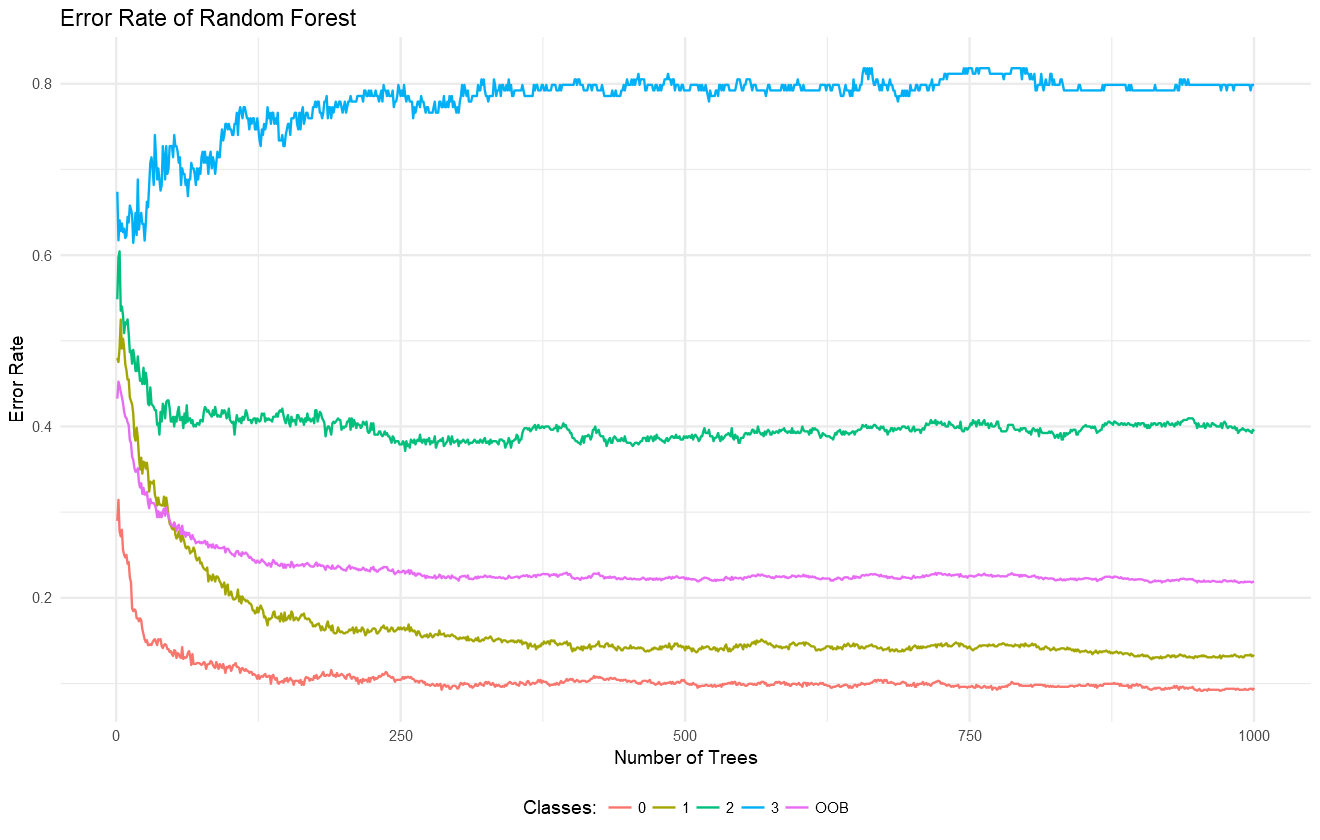

In [165]:
options(repr.plot.width=11, repr.plot.height=7)

# get the error rates from the bagged tree
forest.error <- melt(tree.forest.2$err.rate)

# rename columns
names(forest.error) <- c("x", "variable", "value")

# plot
ggplot(forest.error) + geom_line(aes(x=x, y=value, color = as.factor(variable))) + theme_minimal() + 
    labs(x="Number of Trees", y="Error Rate", title="Error Rate of Random Forest", color="Classes: ") +
    theme(legend.position = 'bottom')

<div class="alert alert-block alert-info">**Summary of Ensemble Method for Trees**</div>

By implementing ensemble methods on trees, we were able to the testing accuracy. Kappa scores and F1 scores have both increased. The training accuracy is 100% for both methods because they are made up of unpruned decision trees.

|Type|OOB Error Rate|Training Accuracy|Testing Accuracy|Kappa Score|Macro Avg. F1|
|----|-----|------------|----------------|-----------|-------------|
|Bagging|23.54%|100%|74.7%|0.6065|0.674|
|Random Forest|21.88%|100%|76.33%|0.6431|0.653|

### 5.3 K-Nearest Neighbor (KNN)

KNN is a *non-parametric lazy learning* algorithm. Unlike other models that makes assumptions about the distribution of the data (linear, gaussian etc), non-parametric algorithm does not make any assumptions about the dataset. KNN does not use any of the training points to do generalization, making it a lazy algorithm. Because of this, the training data is needed during the testing phase. Therefore, when calling the `knn()` function, we will need to put in the following arguments:<br>
`knn(train, test, train$Result, k=k, )` <Br>-- *notice that we needed to put the training set in, which is different from the other methods we have ran so far.*

In [166]:
library(class)

**Choosing optimal number of neighbors**<Br>
We run KNN with k ranging from 5 to 100 with increments of 5. We will use the k that returns the highest accuracy.

In [167]:
set.seed(5)
K <- seq(5, 100, 5)
acc.knn <- data.frame("K"=K, acc=rep(0,length(K)))

for (k in K){
    KNN <- knn(train, test, train$Result, k=k)
    acc.knn[acc.knn$K==k,'acc'] <- acc(test$Result, KNN)
}

**Plot**

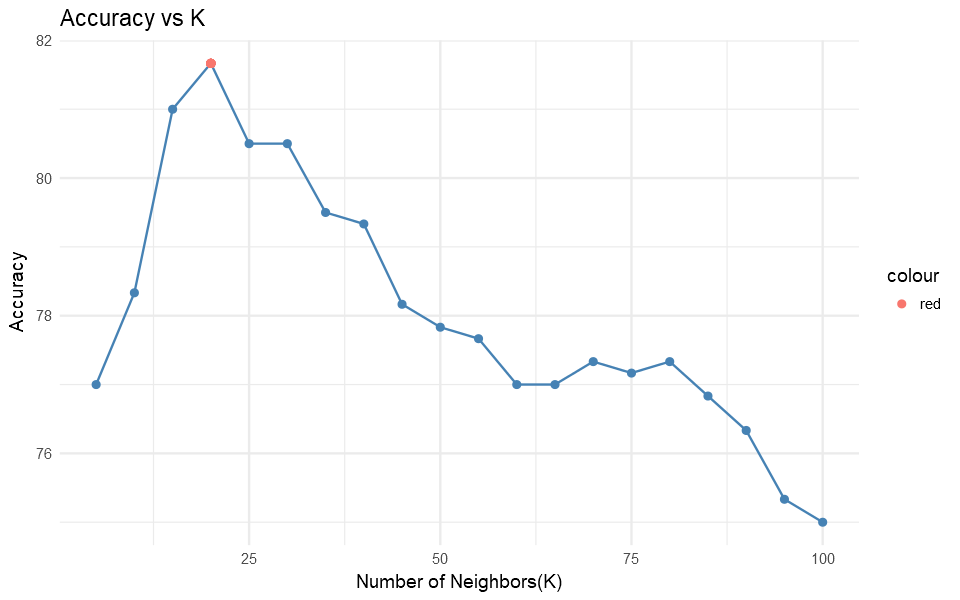

In [168]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(acc.knn, aes(x=K, y=acc)) + geom_line(color='steelblue') + geom_point(color='steelblue') + theme_minimal() +
    geom_point(aes(x=acc.knn[which.max(acc.knn$acc), 'K'], y=acc.knn[which.max(acc.knn$acc), 'acc'], color='red')) +
    labs(x="Number of Neighbors(K)", y="Accuracy", title="Accuracy vs K")

In [169]:
cat("The optimal number of neighbors is: ")
acc.knn[which.max(acc.knn$acc), ]

The optimal number of neighbors is: 

,K,acc
4,20,81.66667


**Rerun KNN with k=20, and generate confusion matrix**

In [170]:
KNN.pred <- knn(train, test, train$Result, k=20)

In [171]:
cat("\n--- KNN with k=20 ---\n")
confusionMatrix(KNN.pred, test$Result, mode="prec_recall")

cat("\nMacro-Averaged F1")
round(mean(t(confusionMatrix(KNN.pred, test$Result, mode="prec_recall")$byClass)[7,]),3)


--- KNN with k=20 ---


Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 210  24   0   0
         1   9 192  41   0
         2   0   6  76  32
         3   0   0   0  10

Overall Statistics
                                          
               Accuracy : 0.8133          
                 95% CI : (0.7798, 0.8437)
    No Information Rate : 0.37            
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7215          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Precision              0.8974   0.7934   0.6667  1.00000
Recall                 0.9589   0.8649   0.6496  0.23810
F1                     0.9272   0.8276   0.6580  0.38462
Prevalence             0.3650   0.3700   0.1950  0.07000
Detection Rate         0.3500   0.3200   0.1267  0.01667
Detection Prevalence   0.3900   0.4033   0.1900  0.01667
Balanced Accuracy      0.9


Macro-Averaged F1

[1] 0.699

KNN had a kappa score of 0.7166 and a macro-averaged F1 of 0.698. Looking at the balanced accuracy, it is clearly biased towards the larger classes, mainly class 0 and class 1. 

## 6. Conclusion

The prostate cancer was critically analysed using various methods of classifications. Principal component analyses was used to visualise the data. It shows that most of the labels were linearly seperatable. This led to the use both linear models and non-linear models to classify the data. Firstly, there were some missing values in some of the attributes. These values were imputed using the Lasso as it had the lowest RMSE. Three different types of classification methods -- Support Vector Machine, classification trees, and K-nearest Neighbours were trained and built. 

Kappa, macro-averaged F1, and balanced accuracy was used as the evaluation metric for all of the classification models. The one that performed the best was SVM using the linear kernel and it resulted to 100% classification accuracy.

## 7. Reference
- [What are C and gamma with regards to a support vector machine?](https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine)
- [Classification Accuracy is Not Enough: More Performance Measures You Can Use](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)
- [A Detailed Introduction to K-Nearest Neighbor (KNN) Algorithm](https://saravananthirumuruganathan.wordpress.com/2010/05/17/a-detailed-introduction-to-k-nearest-neighbor-knn-algorithm/)
- [Comparing Tree-Based Classification Methods via the Kaggle Otto Competition](https://www.r-bloggers.com/comparing-tree-based-classification-methods-via-the-kaggle-otto-competition/)